# Entrega 2 - Aprendizaje Bayesiano

### Grupo 50:
    - M. Ramilo (5.665.788-5)
    - G. Dinello (5.031.022-5)
    - F. Crocamo (4.732.816-6)

## 1. Objetivo

El objetivo central de esta tarea es crear un **predictor de palabras** que funcione de manera similar a las sugerencias de palabras que encontramos en los teclados de dispositivos celulares, y para lograrlo, vamos a emplear el algoritmo **Naive Bayes**. Para entrenar este modelo, utilizaremos un chat extenso extraído de **WhatsApp**. Esta elección de datos presenta desafíos particulares de preprocesamiento debido a la naturaleza informal y variada de las conversaciones en WhatsApp.

En esencia, estamos buscando desarrollar una herramienta que sea capaz de **predecir la siguiente palabra** basándose en el contexto de lo que se ha escrito previamente. Esto puede ser especialmente útil en la escritura de mensajes rápidos y eficientes en dispositivos móviles, ya que ahorra tiempo al usuario al sugerir las palabras más probables de acuerdo con el contexto.

## 2. Preprocesamiento

Como se mencionó anteriormente, esta sección del proyecto se centra en la etapa de preprocesamiento de los datos, que es una fase fundamental para optimizar el chat original extraído de WhatsApp y prepararlo adecuadamente para su uso en el entrenamiento del modelo de predicción de palabras. Esta etapa desempeña un papel esencial en la calidad y eficacia del predictor de palabras que estamos desarrollando.

### 2.1 Cargamos el chat

In [1]:
filename = "chat.txt"

with open(filename, "r", encoding="utf-8") as file:
    data = file.readlines()

raw_chat = []

for line in data:
    parts = line.split(":")
    message = parts[-1].strip()
    raw_chat.append(message)

### 2.2 Preprocesamos el chat

Preprocesamos el chat para eliminar todos los elementos que disminuyen la calidad del predictor que queremos construir.

Los elementos filtrados son:

*   URLs
*   Menciones ("@alguien")
*   Risas
*   Caracteres especiales
*   Palabras con letras repetidas ("vamosss", "biennnn", etc...)

Se aplicaron transformaciones a abreviaciones de palabras para mantener consistencia en predicciones. Algunos ejemplos son:

*   "tmb" a "también"
*   "xq" a "porque"
*   "q" a "que"


In [2]:
import re

# Expresiones regulares
URL = r"https?://\S+"
MENTION = r"@\S+"
LAUGH = r"(?:[aA]*(?:[jJ][aA]*)+[jJ]?)\b"
NOT_LETTERS = r"[^a-zñáéíóú\s]"
REPEATED_LETTERS = r"([a-zñáéíóú])\1{2,}"

# Mapeo de palabras informales a palabras formales
INFORMAL_TO_FORMAL = {
    "q": "que",
    "ke": "que",
    "k": "que",
    "xq": "porque",
    "porq": "porque",
    "pq": "porque",
    "p": "para",
    "pa": "para",
    "d": "de",
    "n": "en",
    "tb": "también",
    "tmb": "también",
    "tmbn": "también",
    "tmbien": "también",
    "tmbn": "también",
    "tambn": "también",
    "toy": "estoy",
    "tas": "estas",
    "ta": "está",
    "tan": "estan",
    "tamos": "estamos",
    "tamo": "estamos",
    "pal": "para el",
    "vamo": "vamos",
    "bue": "bueno",
    "boe": "bueno",
    "buee": "bueno",
    "bn": "bien",
}


def preprocess_chat(chat: list) -> list:
    """Preprocesa el chat de WhatsApp, convirtiendo todas las letras en minusculas, eliminando URLs, menciones, risas, caracteres especiales, letras repetidas y mensajes vacios. Reemplaza palabras informales por sus equivalentes formales. Finalmente, ordena los mensajes alfabeticamente y elimina duplicados.

    Args:
    chat (list): Lista de mensajes del chat de WhatsApp

    Returns:
    list: Lista de mensajes preprocesados
    """
    chat = [message.lower() for message in chat]

    chat = [re.sub(URL, "", message) for message in chat]
    chat = [re.sub(MENTION, "", message) for message in chat]
    chat = [re.sub(NOT_LETTERS, "", message) for message in chat]
    chat = [re.sub(LAUGH, "", message) for message in chat]
    chat = [re.sub(REPEATED_LETTERS, r"\1", message) for message in chat]

    for informal, formal in INFORMAL_TO_FORMAL.items():
        chat = [re.sub(r"\b{}\b".format(informal), formal, message) for message in chat]

    chat = [message.strip() for message in chat]
    chat = [message for message in chat if message != ""]

    chat = [re.sub(r"\s+", " ", message) for message in chat]
        
    chat = list(dict.fromkeys(chat))
    return chat

chat = preprocess_chat(raw_chat)

## 3. Estructuras de datos

Para lograr un funcionamiento eficiente debemos crear las estructuras de datos adecuadas para el problema a resolver. A la hora de correr el predictor, necesitaremos tiempos de búsqueda casi instantaneos, de otra manera el predictor en lugar de ayudar al usuario lo estaría trancando y estorbando.

Para lograr esto, utilizaremos **tablas de hash (diccionarios en Python)** para almacenar las probabilidades y cantidad de ocurrencia de palabras, esto nos permite realizar las búsquedas en **O(1)**.

Por otro lado, construiremos una lista para almacenar el vocabulario, ya que en cada predicción a realizar tendremos que recorrer todo el vocabulario en busca de la palabra mas probable (Hipotesis MAP).

De esta forma podemos conseguir tiempos de predicción de **O(N)** siendo N la cantidad de palabras en el vocabulario.

### 3.1 Cargamos diccionario de palabras en español

El mismo será utilizado para cruzarlo con nuestro vocabulario generado a partir del chat y así eliminar palabras no deseadas. Además que de esta forma conseguimos modelar un predictor de palabras base sin ningún sesgo de nuestro chat, haciéndolo mas generalizable y apto para cualquier usuario.

In [3]:
filename = "es.txt"

with open(filename, "r", encoding="utf-8") as file:
   data = file.readlines()

spanish_dict = set()

for line in data:
   word = line.strip()
   spanish_dict.add(word)

spanish_dict.add('y')

In [4]:
len(spanish_dict)

636599

### 3.2 Creamos diccionario de ocurrencia de palabras y vocabulario

In [5]:
def build_word_count(chat, spanish_dict=None):
    words_list = " ".join(chat).split(" ")
    
    # filtrado de palabras con diccionario
    if spanish_dict is not None:
        filtered_words_list = [word for word in words_list if word in spanish_dict]
    else:
        filtered_words_list = words_list
    
    # conteo de ocurrencias de cada palabra
    words_count = {}
    for word in filtered_words_list:
        if word in words_count:
            words_count[word] += 1
        else:
            words_count[word] = 1
            
    return words_count

def build_vocabulary(words_count):
    return list(words_count.keys())

### 3.3 Definimos funciones para manejar los diccionarios de probabilidades

Definimos las funciones necesarias para construir y actualizar los diccionarios que almacenan las probabilidades de **P(H)** y **P(D|H)**.

In [6]:
# Construimos diccionario de probabilidades P(H), probabilidad a priori
def build_ph(total_words) -> dict[str, float]:
    ph_dict = {word: frequency / total_words for word, frequency in words_count.items()}
    return ph_dict

# Construimos diccionario de probabilidades P(D|H) en base al hiperparametro N (Cantidad de palabras a considerar)
def build_pdh(chat: list, N=1) -> dict[str, dict[str, float]]:
    pdh_dict, pdh_dict_count = {}, {}
    for message in chat:
        words = message.split(" ")
        words = [word for word in words if word in vocabulary]
        if len(words) > 1:
            for key, val in enumerate(words):
                if (val not in pdh_dict_count.keys()):
                    pdh_dict[val] = {}
                    pdh_dict_count[val] = {}
                if key >= 1:
                    initial = 0 if key-N < 0 else key-N
                    N_words_before = set(words[initial:key])
                    for word_before in N_words_before:
                        if not word_before in pdh_dict_count[val]:
                            pdh_dict[val][word_before] = 0
                            pdh_dict_count[val][word_before] = 0
                        pdh_dict_count[val][word_before] += 1

    for key in pdh_dict.keys():
        for subkey in pdh_dict[key].keys():
            pdh_dict[key][subkey] = pdh_dict_count[key][subkey] / words_count[subkey]

    return pdh_dict, pdh_dict_count


def update_pdh(pdh_dict, pdh_dict_count, new_message, N=1):
    words = new_message.split(" ")
    words = [word for word in words if word in vocabulary]
    if len(words) > 1:
        for key, val in enumerate(words):
            if (val not in pdh_dict_count.keys()):
                pdh_dict_count[val] = {}
                pdh_dict[val] = {}
            if key >= 1:
                initial = 0 if key-N < 0 else key-N
                N_words_before = set(words[initial:key])
                for word_before in N_words_before:
                    if not word_before in pdh_dict_count[val]:
                        pdh_dict_count[val][word_before] = 0
                        pdh_dict[val][word_before] = 0
                    pdh_dict_count[val][word_before] += 1

    for key in pdh_dict.keys():
        for subkey in pdh_dict[key].keys():
            pdh_dict[key][subkey] = pdh_dict_count[key][subkey] / words_count[subkey]
            
    return pdh_dict, pdh_dict_count


### 3.4 Definimos la función de entrenamiento del modelo

Decidimos crear una función de entrenamiento para poder reutilizar el código ya que el modelo se re-entrenará cada vez que el usuario termine una frase. Construimos todas las estructuras necesarias para el funcionamiento del modelo o las actualizamos en caso de que estemos re-entrenando el modelo.

Como se podrá observar, decidimos no cruzar las nuevas frases que ingrese el usuario con el diccionario de palabras en español, ya que consideramos que el usuario puede querer utilizar palabras que no estén en el diccionario, y de esta forma, el predictor se irá adaptando paulatinamente a sus gustos.

In [7]:
def train(pdh_dict, pdh_dict_count, N=2, chat=chat, spanish_dict=spanish_dict):
    global total_words, vocabulary, words_count
    words_count = build_word_count(chat, spanish_dict=spanish_dict)
    total_words = sum(words_count.values())
    vocabulary = build_vocabulary(words_count)   
    ph = build_ph(total_words)
    if pdh_dict_count is None:
        pdh_dict, pdh_dict_count = build_pdh(chat, N=N)
    else:
        pdh_dict, pdh_dict_count = update_pdh(pdh_dict, pdh_dict_count, chat[-1], N=N)
    return ph, pdh_dict, pdh_dict_count

## 4. Implementación

### 4.1 Creamos las estructuras necesarias

Definimos las stopwords, el hiperparámetro N y creamos los diccionarios de probabilidades **P(H)** y **P(D|H)**.

In [8]:
import nltk
nltk.download('stopwords')

# Definimos stopwords a considerar al momento de predecir
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.append("no")
stopwords.append("si")
stopwords.append("mas")
stopwords.append("que")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Utilizamos el hiperpárametro con valor 3

In [9]:
N=3
ph_dict, pdh_dict, pdh_dict_count = train(None, None, N=3, chat=chat, spanish_dict=spanish_dict)

### 4.2 Creacion del predictor

Construimos la función `recomendacion_bayesiana` que dada una frase devuelve la palabra sugerida. Para esto calculamos la **Hipótesis MAP** utilizando el **m-estimador** para los casos que nunca se habian visto en el entrenamiento del modelo.

In [10]:
def recomendacion_bayesiana(frase):
    if len(frase) >= N:
        keys = frase[-N:]
    else:
        keys = frase
    keys = [k.lower() for k in keys]

    # Bucar la palabra con mayor probabilidad, es decir, que maximice P(H|D) = P(D|H) * P(H) (Hipoteses MAP)
    max_prob = 0
    palabra_sugerida = ""
    last_is_stopword = True if keys[-1] in stopwords else False
    for word in vocabulary:
        # evita caer en ciclos de recomendacion de stopwords
        if last_is_stopword and word in stopwords:
            continue
        prob = None
        for key in keys:
            m_estimator = 1 / (words_count.get(key, 0) + len(vocabulary))
            if prob is None:
                prob = pdh_dict.get(word, {}).get(key, m_estimator)
            else:
                prob = prob * pdh_dict.get(word, {}).get(key, m_estimator)
        prob *= ph_dict[word]
        if prob >= max_prob:
            max_prob = prob
            palabra_sugerida = word

    return palabra_sugerida

In [11]:
example_frases = [
    "esto es una prueba",
    "me parece muy",
    "nos juntamos en tu",
]
for frase in example_frases:
    print(frase + " " + recomendacion_bayesiana(frase.split(" ")))

esto es una prueba de
me parece muy bien
nos juntamos en tu casa


### 4.3 Playground

In [12]:

##### LOOP PRINCIPAL #####

print("Ingrese la frase dando ENTER luego de \x1b[3mcada palabra\x1b[0m.")
print("Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER")
print("Ingrese '.' para comenzar con una frase nueva.")
print("Ingrese '..' para terminar el proceso.")
frase = []
palabra_sugerida = ""
while 1:
    palabra = input(">> ")

    if palabra == "..":
        break

    elif palabra == ".":
        print("----- Comenzando frase nueva -----")
        chat.append(" ".join(frase))
        ph_dict, pdh_dict, pdh_dict_count = train(pdh_dict, pdh_dict_count, N=N, chat=chat, spanish_dict=spanish_dict)
        frase = []

    elif palabra == "": # acepta última palabra sugerida
        frase.append(palabra_sugerida)

    else: # escribió una palabra
        frase.append(palabra)

    if frase:
        palabra_sugerida = recomendacion_bayesiana(frase)

        frase_propuesta = frase.copy()
        frase_propuesta.append("\x1b[3m"+ palabra_sugerida +"\x1b[0m")

        print(" ".join(frase_propuesta))


Ingrese la frase dando ENTER luego de cada palabra.
Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER
Ingrese '.' para comenzar con una frase nueva.
Ingrese '..' para terminar el proceso.


### 5. Evaluacion

Por la naturaleza no deterministica del lenguaje natural, no es simple evaluar la performance del predictor. Por lo tanto, proponemos un metodo de evaluación que conocemos tiene limitaciones pero que al menos nos permitirá establecer una base comparativa entre distintos modelos. 

Tomaremos 1000 frases elegidas al azar (y que tengan al menos N+1 cantidades de palabras) del chat. Para cada uno de estos mensajes elegiremos una palabra (dentro del rango $[N+1, |\text{words in mensaje}|]$ ), la cual deberá ser predecida por el modelo. Si el modelo predice exactamente dicha palabra se considera un acierto, de lo contrario, se considera un error.

Entrenaremos el modelo con valores en el rango 1 a 4 del hiperparámetro N, y repetiremos esto para dos variantes, una entrenada sobre el chat completo y otra con el chat filtrado con el diccionario de palabras en español.

In [13]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

# hiperparametro N
N = 4 
# setearlo en 4 nos permite testear a todos los modelos con el mismo test set de mensajes.
# si el modelo utiliza una ventana de contexto menor simplemente se ignoran las primeras palabras del contexto

shuffled_chats = chat.copy()
random.shuffle(shuffled_chats)
## Preparamos el test set
test_set = []
# Elegimos 1000 mensajes al azar
index = 0
while len(test_set) < 1000 and index < len(shuffled_chats):
    msg = shuffled_chats[index]
    index += 1
    words = msg.split(" ")
    if len(words) <= N:
        continue
    # elijo la word que tengo que predecir dentro del mensaje
    to_predict = np.random.randint(N, len(words))
    context = words[to_predict-N:to_predict]
    # ejeplo, N=3
    # words = ["a","b","c","d"]
    # to_predict = 3 <= rand < 4
    # context = words[3-3:3] = words[0:3] = ["a","b","c"]
    test_set.append((context, words[to_predict]))

len(test_set)

1000

In [14]:
import time 

resultado, training_time = [], []
res_filtered, training_time_filtered = [], []
for dictionary in [None, spanish_dict]: 
    for i in range(1,5):
        N = i # hay que modificar el N puesto que recomendacion bayesiana lo utiliza
        
        start = time.time()
        ph_dict, pdh_dict, pdh_dict_count = train(None, None, N=i, chat=chat, spanish_dict=dictionary)
        lapse = time.time() - start
        
        if dictionary is None:
            training_time.append(lapse)
        else:
            training_time_filtered.append(lapse)
        
        correctas = 0
        for context, word in test_set:
            prediction = recomendacion_bayesiana(context)
            correctas += 1 if prediction == word else 0

        if dictionary is None:
            resultado.append(correctas)
        else:
            res_filtered.append(correctas)

In [15]:
print("Con filtro:")
print("\tAciertos ", res_filtered)
print("\tTiempos de entrenamiento ", training_time_filtered)

print("Sin filtro:")
print("\tAciertos ", resultado)
print("\tTiempos de entrenamiento ", training_time)

Con filtro:
	Aciertos  [68, 114, 119, 102]
	Tiempos de entrenamiento  [6.482893705368042, 6.3500707149505615, 6.579882621765137, 7.125468015670776]
Sin filtro:
	Aciertos  [129, 176, 201, 170]
	Tiempos de entrenamiento  [4.493280410766602, 5.182491779327393, 5.157037734985352, 5.305946350097656]


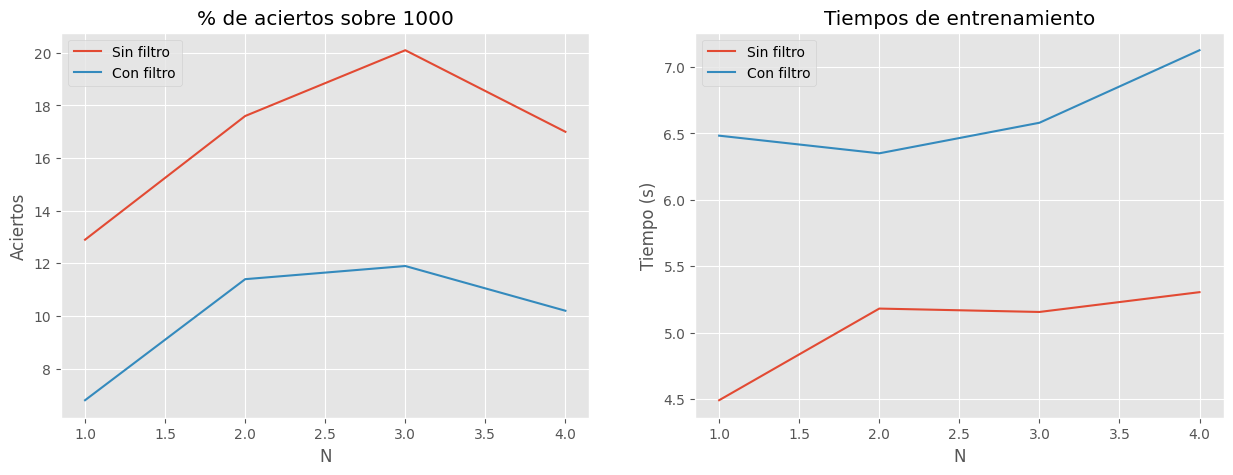

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True)

ax[0].set_title("% de aciertos sobre 1000")
ax[0].set_xlabel("N")
ax[0].set_ylabel("Aciertos")

ax[1].set_title("Tiempos de entrenamiento")
ax[1].set_xlabel("N")
ax[1].set_ylabel("Tiempo (s)")

ax[0].plot(range(1,5), [(res / 1000) * 100 for res in resultado] , label="Sin filtro")
ax[0].plot(range(1,5), [(res / 1000) * 100 for res in res_filtered] , label="Con filtro")

ax[1].plot(range(1,5), training_time, label="Sin filtro")
ax[1].plot(range(1,5), training_time_filtered, label="Con filtro")

ax[0].legend()
ax[1].legend()
ax[0].grid(1)
ax[1].grid(1)
plt.show()

Vemos que el modelo entrenado con el chat filtrado tiene un peor desempeño sobre el conjunto de testing. Sin embargo, esto es esperable y es un defecto de la metodología de testeo elegida. 

El filtrado quitará palabras del conjunto de entrenamiento, algunas de estas serán luego elegidas para testear y puesto que el modelo no las vió en su entrenamiento no podrá predecirlas. Además, el filtrado "despersonalizará" al modelo, ya que el mismo no tendrá en cuenta palabras que el usuario utiliza frecuentemente (y fueron filtradas), un sesgo que si existirá en el conjunto de testeo.

Podemos observar que, en general, los modelos mejoran su desempeno al utilizar un mayor valor para el hiperparametro N. Esto es esperable, ya que al aumentar N, el modelo tendrá en cuenta un mayor contexto a la hora de predecir la siguiente palabra.

Sin embargo, esta mejora se estanca al llegar a 3. Esto puede deberse al largo promedio de los mensajes del chat, si estos en general son cortos, menores a 3 el modelo no podra utilizar mas contexto porque no lo hay.

In [17]:
import numpy as np

# longitud media de los mensajes en el chat
longitudes = [len(msg.split(" ")) for msg in chat]
longitud_media_chat = np.mean(longitudes)
desvio_chat = np.std(longitudes)
longitud_mediana_chat = np.median(longitudes)

print(longitud_media_chat)
print(desvio_chat)
print(longitud_mediana_chat)

4.914876112120922
3.0288206604843015
4.0


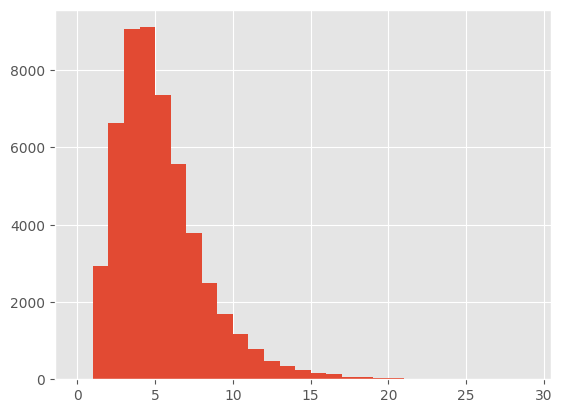

In [18]:
# plot de la distribucion de longitudes de los mensajes en el chat

import matplotlib.pyplot as plt

plt.hist(longitudes, bins=range(0, 30, 1))
plt.show()


#### Evaluacion de probabilidades

Utilizando un chat artificial de pequeño tamaño podemos evaluar el algoritmo que calcula las probabilidades para las predicciones.


In [19]:
test_chat = [
    "buenos dias todo bien",
    "volveran en unos dias de las vacaciones",
]

ph_dict, pdh_dict, _ = train(None, None, N=1, chat=test_chat, spanish_dict=None)

In [20]:
pdh_dict

{'buenos': {},
 'dias': {'buenos': 1.0, 'unos': 1.0},
 'todo': {'dias': 0.5},
 'bien': {'todo': 1.0},
 'volveran': {},
 'en': {'volveran': 1.0},
 'unos': {'en': 1.0},
 'de': {'dias': 0.5},
 'las': {'de': 1.0},
 'vacaciones': {'las': 1.0}}

Podemos observar que no se establecio un P(D|buenos) ni P(D|volveran) ya que ambas son primeras palabras. Para estos casos se utiliza un m_estimador teniendo en cuenta la frecuencia de ambas palabras.

In [21]:
1 / (words_count["buenos"] + len(vocabulary))

0.09090909090909091

Esta probabilidad se usa como valor por defecto para los casos donde se calcula como sugerencia la palabra "buenos"

La palabra "dias" tiene 2 valores en su diccionario. Esto corresponde a las palabras previas que se encuentran en el texto:
- "buenos **dias**..."
- "...en unos **dias**..."

Su P(D|dias) tiene valor 1 ya que tanto para "buenos" como "unos" solo hay una muestra, por lo tanto tiene sentido recomendar "dias" en ambos casos


Se puede apreciar que tanto "todo" como "de" tienen en su diccionario a "dias" con un valor de 0.5. Esto se puede interpretar como equiprobabilidad entre recomendar "todo" o "de" luego de "dias" y se justifica por dos apariciones en los textos:

- "buenos **dias** todo..."
- "...unos **dias** de las vacaciones"

El diccionario P(H) correspondiente al chat artificial es el siguiente:

In [22]:
ph_dict

{'buenos': 0.09090909090909091,
 'dias': 0.18181818181818182,
 'todo': 0.09090909090909091,
 'bien': 0.09090909090909091,
 'volveran': 0.09090909090909091,
 'en': 0.09090909090909091,
 'unos': 0.09090909090909091,
 'de': 0.09090909090909091,
 'las': 0.09090909090909091,
 'vacaciones': 0.09090909090909091}

Con un total de 11 palabras en todo el chat, habiendo 10 palabras distintas se confirma que todas las palabras tienen una probabilidad de 1/11 excepto "dias" que, apareciendo 2 veces en el chat, tiene 2/11

Se puede agregar una nueva frase al chat y reentrenar el modelo


In [23]:

test_chat.append("cuantos dias faltan para el parcial")
ph_dict, pdh_dict, _ = train(None, None, N=1, chat=test_chat, spanish_dict=None)

El nuevo diccionario de probabilidades actualizado es:

In [24]:
pdh_dict

{'buenos': {},
 'dias': {'buenos': 1.0, 'unos': 1.0, 'cuantos': 1.0},
 'todo': {'dias': 0.3333333333333333},
 'bien': {'todo': 1.0},
 'volveran': {},
 'en': {'volveran': 1.0},
 'unos': {'en': 1.0},
 'de': {'dias': 0.3333333333333333},
 'las': {'de': 1.0},
 'vacaciones': {'las': 1.0},
 'cuantos': {},
 'faltan': {'dias': 0.3333333333333333},
 'para': {'faltan': 1.0},
 'el': {'para': 1.0},
 'parcial': {'el': 1.0}}

Se puede observar que todas las palabras del diccionario relacionadas a la palabra "dias" fueron actualizadas, disminuyendo su probabilidad condicional como resultado de una nueva frase que la incluye. Ademas se agregaron las nuevas palabras y se calculo su probabilidad incluyendo palabras anteriores.

A modo de ejemplo se puede calcular P("buenos"|"dias") utilizando el teorema de bayes, asumiendo independencia entre las palabras previas como:

P("buenos"|"dias") = P("dias"|"buenos") * P("buenos") / P("dias")

In [25]:
pdh_dict["dias"]["buenos"] * ph_dict["buenos"] / ph_dict["dias"]

0.3333333333333333